In [1]:
import os
import yaml
import torch
import numpy as np
import sys

import inspect
import importlib


import matplotlib.pyplot as plt
import math


# Dynamically add the parent directory of 'modules' to sys.path
current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
sys.path.append(parent_dir)
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

# Now you can import NoiseGenerator
from modules.noise_generator import NoiseGenerator

# Define paths
DATASET = "MNIST"  # Replace with your dataset name
BASE_PATH = f"../{DATASET}"
MODELS_PATH = f"{BASE_PATH}/models"
WANDB_PATH = f"{BASE_PATH}/wandb"


In [2]:
def find_architecture(run_id):
    """
    Find the architecture details for the given run_id from wandb config files.
    """
    # Search for the wandb run directory matching the run_id
    for dirpath, _, filenames in os.walk(WANDB_PATH):
        # Check if the folder name ends with the run_id
        if dirpath.endswith(f"-{run_id}"):
            config_file = os.path.join(dirpath, "files", "config.yaml")
            if os.path.exists(config_file):
                with open(config_file, "r") as f:
                    config = yaml.safe_load(f)
                
                # Extract architecture and return full config
                architecture = config['model_ref']['value']
                return architecture, config
    raise FileNotFoundError(f"No configuration found for run_id: {run_id}")

In [3]:
# Example usage
run_id = "rqd8j2mv"
try:
    architecture, _ = find_architecture(run_id)
    print("Configuration loaded successfully:")
    print(architecture)
except FileNotFoundError as e:
    print(e)


Configuration loaded successfully:
vanilla_deep


In [4]:
# Add the parent directory to sys.path
current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
sys.path.append(parent_dir)

def get_generator_params(architecture):
    """
    Dynamically load the Generator class from the architecture module and extract its parameters.
    """
    # Dynamically import the architecture module
    module = importlib.import_module(f"architectures.{architecture}")
    
    # Get the signature of the Generator class's __init__ method
    generator_class = module.Generator
    init_signature = inspect.signature(generator_class.__init__)
    
    # Extract parameter names and default values
    params = {}
    for name, param in init_signature.parameters.items():
        if name == "self":
            continue  # Skip 'self'
        params[name] = param.default if param.default != inspect.Parameter.empty else None
    
    return params

In [5]:
get_generator_params(architecture)

{'input_size': None,
 'hidden_size': None,
 'output_size': None,
 'hidden_layers': None,
 'reduction_factor': 0.8}

In [6]:
def find_weights(run_id, model_type):
    """
    Find the weights file (.pth) for the given run_id and model type (generator/discriminator).
    """
    global MODELS_PATH

    models_dir = MODELS_PATH  # Adjust this path if necessary
    
    # Search for the weights file matching the run_id and model_type
    for filename in os.listdir(models_dir):
        if filename.startswith(f"{model_type}_{run_id}_") and filename.endswith(".pth"):
            return os.path.join(models_dir, filename)
    
    raise FileNotFoundError(f"No weights found for {model_type} with run_id: {run_id}")

In [7]:
# Example usage
run_id = "rqd8j2mv"

# Test finding generator weights
try:
    generator_weights = find_weights(run_id, "generator")
    print("Generator weights found:", generator_weights)
except FileNotFoundError as e:
    print(e)

# Test finding discriminator weights
try:
    discriminator_weights = find_weights(run_id, "discriminator")
    print("Discriminator weights found:", discriminator_weights)
except FileNotFoundError as e:
    print(e)

Generator weights found: ../MNIST/models/generator_rqd8j2mv_250203181507.pth
Discriminator weights found: ../MNIST/models/discriminator_rqd8j2mv_250203181507.pth


In [8]:
def load_generator(run_id):
    """
    Load the Generator model based on the run_id.
    """
    # Step 1: Find architecture details and full config
    architecture, config = find_architecture(run_id)
    
    # Step 2: Dynamically import the architecture module
    try:
        current_dir = os.path.dirname(os.path.abspath(__file__))
    except NameError:
        current_dir = os.getcwd()
    
    parent_dir = os.path.dirname(current_dir)
    architectures_dir = os.path.join(parent_dir, "architectures")
    
    if architectures_dir not in sys.path:
        sys.path.append(architectures_dir)
    
    module = importlib.import_module(architecture)
    
    # Step 3: Identify expected parameters for the Generator
    expected_params = get_generator_params(architecture)
    
    # Step 4: Extract parameter values from config.yaml
    generator_params = {}
    for param_name, default_value in expected_params.items():
        # Map parameter names to config keys
        if param_name == "input_size":
            generator_params[param_name] = config['latent_size']['value']
        elif param_name == "hidden_size":
            generator_params[param_name] = config['hidden_size']['value']
        elif param_name == "output_size":
            generator_params[param_name] = config['image_size']['value']
        elif param_name == "hidden_layers":
            generator_params[param_name] = config['hidden_layers_g']['value']
        elif param_name == "reduction_factor":
            generator_params[param_name] = config['reduction_factor']['value']
        else:
            # Use default value if no mapping exists
            generator_params[param_name] = default_value
    
    # Step 5: Instantiate the Generator
    generator = module.Generator(**generator_params)
    
    # Step 6: Load weights
    weights_path = find_weights(run_id, "generator")
    generator.load_state_dict(torch.load(weights_path, map_location=torch.device('cpu'), weights_only=True))
    generator.eval()  # Set to evaluation mode
    
    return generator

In [9]:
run_id = "rqd8j2mv"
G = load_generator(run_id)

In [10]:
def generate_noise_vectors(input_size, num_samples=10):
    """
    Generate N noise vectors with the given input size.
    """
    return torch.randn(num_samples, input_size)  # Sample from a standard normal distribution

def generate_images(generator, noise_vectors):
    """
    Generate images using the Generator and noise vectors.
    """
    generator.eval()  # Ensure the model is in evaluation mode
    with torch.no_grad():  # Disable gradient computation
        images = generator(noise_vectors)
    
    # Reshape images if they are flattened (e.g., for fully connected GANs)
    if len(images.shape) == 2:  # Flattened images
        img_dim = int(images.shape[1] ** 0.5)  # Assume square images
        images = images.view(-1, 1, img_dim, img_dim)  # Reshape to [batch_size, channels, height, width]
    
    return images

def plot_images(images, title, num_samples):
    """
    Display a grid of images with an adaptive layout.
    """
    # Calculate grid layout
    rows, cols = calculate_grid_layout(num_samples)
    
    # Create the plot
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))  # Adjust figure size dynamically
    fig.suptitle(title, fontsize=16)
    
    # Flatten axes for easy iteration
    axes = axes.flatten() if num_samples > 1 else [axes]
    
    for i in range(num_samples):
        ax = axes[i]
        ax.imshow(images[i].squeeze(), cmap="gray")
        ax.axis("off")
    
    # Hide unused subplots
    for i in range(num_samples, len(axes)):
        axes[i].axis("off")
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to fit the title
    plt.show()

def calculate_grid_layout(n_samples):
    """
    Calculate the number of rows and columns for the grid layout.
    """
    if n_samples <= 10:
        # Single row for small numbers of samples
        return 1, n_samples
    else:
        # Use a square-like grid for larger numbers of samples
        cols = int(math.ceil(math.sqrt(n_samples)))
        rows = int(math.ceil(n_samples / cols))
        return rows, cols

def compare_generators(run_ids, architectures, latent_sizes, num_samples=10, noise_vectors=None):
    """
    Compare the outputs of multiple Generators based on their run_ids.
    Parameters:
        run_ids (list): List of run_ids to compare.
        architectures (list): List of architecture names corresponding to each run_id.
        latent_sizes (list): List of latent sizes corresponding to each run_id.
        num_samples (int): Number of samples per Generator.
        noise_vectors (torch.Tensor): Pre-generated noise vectors to use for image generation.
    """
    if noise_vectors is None:
        raise ValueError("Pre-generated noise vectors must be provided.")
    
    for i, (run_id, architecture, latent_size) in enumerate(zip(run_ids, architectures, latent_sizes)):
        try:
            # Step 1: Load Generator
            generator = load_generator(run_id)
            
            # Step 2: Generate images
            images = generate_images(generator, noise_vectors)
            
            # Step 3: Display images for this generator
            plot_images(images, f"Generator {i + 1}: {architecture}", num_samples)
        
        except FileNotFoundError as e:
            print(f"Error for run_id '{run_id}': {e}")
        except KeyError as e:
            print(f"Error for run_id '{run_id}': Missing key in configuration - {e}")
        except Exception as e:
            print(f"Unexpected error for run_id '{run_id}': {e}")

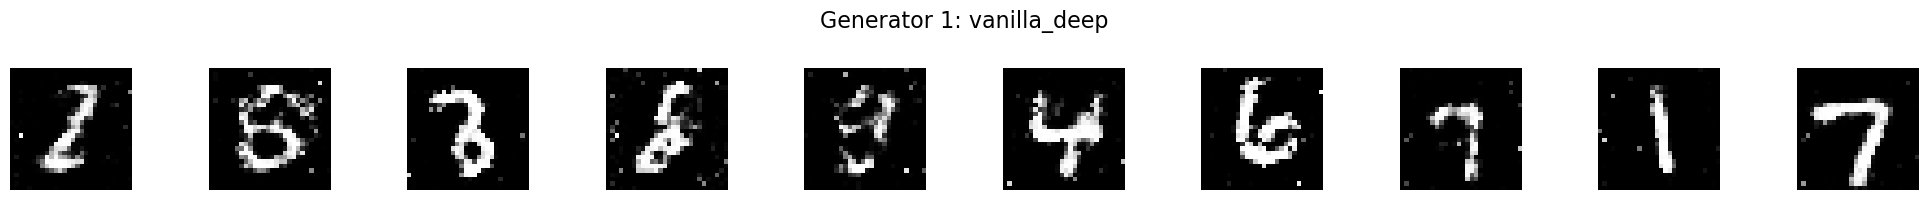

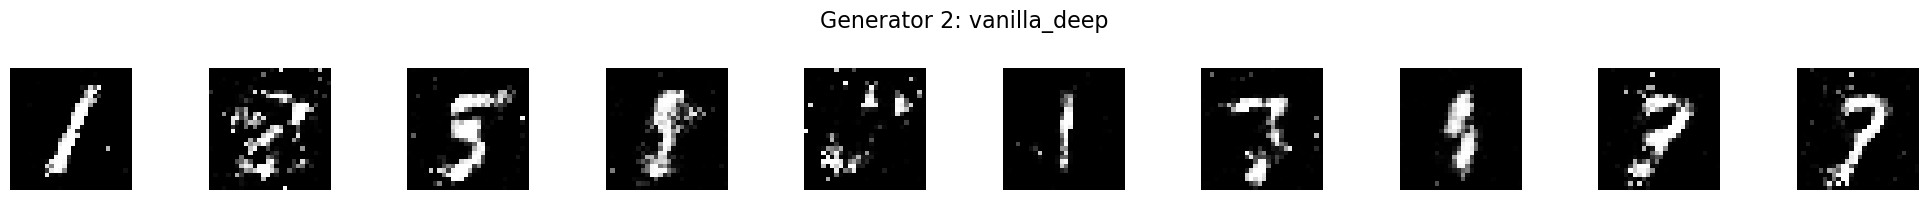

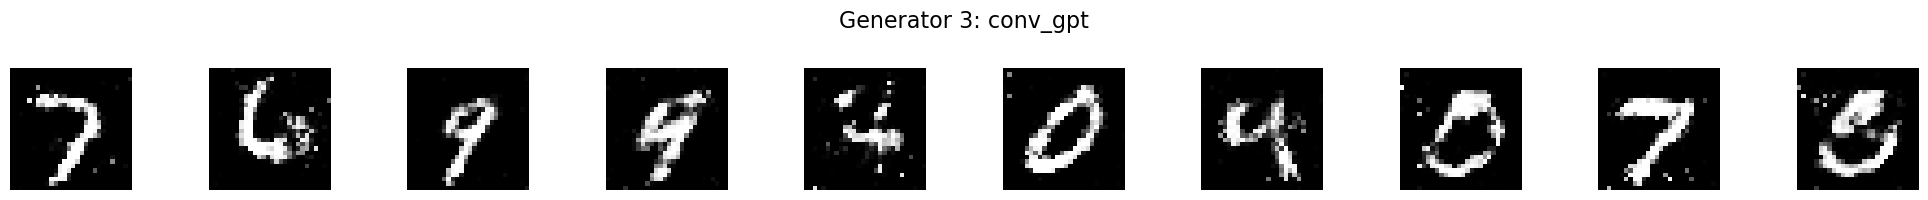

Error for run_id 'n0kk2y6u': No weights found for generator with run_id: n0kk2y6u
Error for run_id 't32grqkk': No weights found for generator with run_id: t32grqkk


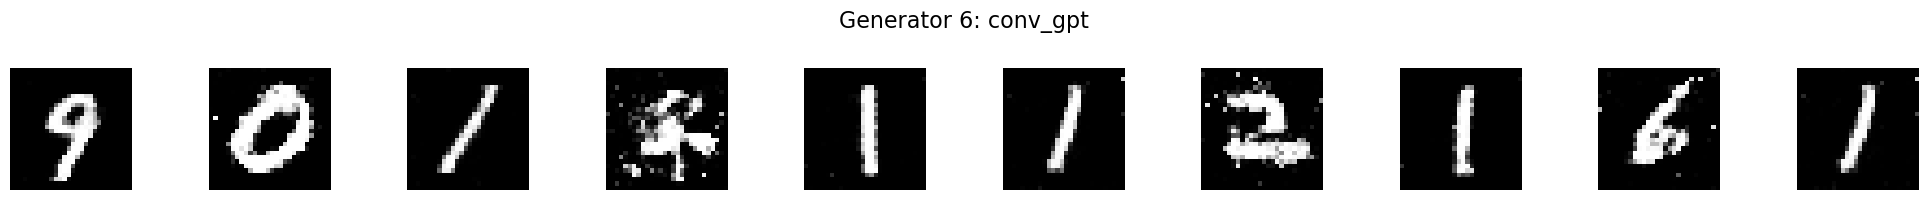

In [16]:
# List of run_ids to compare
run_ids = ["rqd8j2mv", "0aua94i4", "oho43hkl",  "n0kk2y6u", "t32grqkk", "9jzv8psh"]  # Replace with your list of run_ids

# Number of samples per Generator
num_samples = 10  

custom_noise_config = {
    # Options: 'normal', 'uniform', 'exponential', 'lognormal', 'gamma', 'poisson', 'random_binary', 'pfc_sim'.
    "noise_type": "normal",  
    "noise_mean": 0.0,
    "noise_std": 1.0,
    "noise_min": -1.0,
    "noise_max": 1.0,
    "noise_lambda": 1.0,
    "noise_alpha": 2.0,
    "noise_beta": 1.0,
    "d": 4,  # Number of photonic modes (for PFC simulation)
    "l": 1,  # Number of layers (for PFC simulation)
}


# Extract architectures and latent sizes
architectures = []
latent_sizes = []
for run_id in run_ids:
    config = find_architecture(run_id)  # Get full configuration
    architectures.append(config[0])  # Architecture name
    latent_sizes.append(config[1]['latent_size']['value'])  # Latent size

# Use the latent size of the first generator to generate noise vectors
latent_size = latent_sizes[0]  # Assume all generators have the same latent size
custom_noise_config["batch_size"] = num_samples
custom_noise_config["latent_size"] = latent_size

# Initialize NoiseGenerator and generate noise vectors
device = torch.device("cpu")  # Use CPU for noise generation
noise_gen = NoiseGenerator(config=custom_noise_config, device=device)
noise_vectors = noise_gen.generate_noise()

# Compare the Generators
compare_generators(run_ids, architectures, latent_sizes, num_samples=num_samples, noise_vectors=noise_vectors)

In [12]:
def plot_noise_raw(noise_type_, config_, noise_vectors):
    """
    Visualizes raw noise vectors.
    Parameters:
        noise_type_ (str): Type of noise (e.g., 'normal', 'uniform').
        config_ (dict): Configuration parameters for the noise.
        noise_vectors (torch.Tensor): Pre-generated noise vectors to visualize.
    """
    # Prepare to plot
    fig, ax = plt.subplots(figsize=(15, 8))  # Single plot, no need for multiple axes
    
    # Plot the provided noise data
    ax.plot(noise_vectors.cpu().numpy().flatten())  # Plotting the flattened noise
    
    # Create title string from noise type and config
    config_str = ", ".join(f"{k}={v}" for k, v in config_.items())
    ax.set_title(f"{noise_type_.capitalize()} Noise\n{config_str}")
    ax.set_xlabel('Index')
    ax.set_ylabel('Value')
    
    # Show the plot
    plt.show()


import seaborn as sns

def plot_noise_histogram(noise_vectors, noise_type, config):
    """
    Visualizes the histogram and KDE of noise vectors.
    Parameters:
        noise_vectors (torch.Tensor): Pre-generated noise vectors to visualize.
        noise_type (str): Type of noise (e.g., 'normal', 'uniform').
        config (dict): Configuration parameters for the noise.
    """
    z_numpy = noise_vectors.cpu().numpy().flatten()
    
    # Calculate mean and standard deviation
    mean = np.mean(z_numpy)
    std = np.std(z_numpy)
    
    # Plot distribution using Kernel Density Estimation (KDE)
    fig, ax = plt.subplots(figsize=(15, 8))  # Single plot, no need for multiple axes
    sns.histplot(z_numpy, kde=True)
    
    # Format the plot title and labels
    config_str = ", ".join(f"{k}={v}" for k, v in config.items())
    ax.set_title(f"{noise_type.capitalize()} Noise\n{config_str}", fontsize=20)
    ax.set_xlabel('Value', fontsize=18)
    ax.set_ylabel('Density', fontsize=18)
    ax.tick_params(axis='both', which='major', labelsize=18)  # Tick labels font size
    
    # Display mean and standard deviation on the plot
    textstr = f'Mean: {mean:.4f}\nStd: {std:.4f}'
    ax.text(0.95, 0.95, textstr, transform=ax.transAxes,
            fontsize=18, verticalalignment='top', horizontalalignment='right',
            bbox=dict(facecolor='white', alpha=0.5, edgecolor='black'))
    
    plt.show()

def visualize_noise_as_image(noise_vectors, index=0, draw_grid=False):
    """
    Visualizes a single noise vector as a grayscale image, with optional grid lines to delimit each pixel.
    Parameters:
        noise_vectors (torch.Tensor): The batch of noise vectors to visualize, expected shape (batch_size, input_size).
        index (int): The index of the noise vector in the batch to visualize.
        draw_grid (bool): Whether to draw grid lines around the pixels.
    """
    # Extract the specific noise vector and reshape it into the largest possible square/rectangle
    input_size = len(noise_vectors[0])  # Length of the input noise vector
    side = int(np.sqrt(input_size))  # Assume the closest square
    if side * side != input_size:
        rows, cols = get_closest_factors(input_size)  # Use the closest rectangle
    else:
        rows, cols = side, side
    
    # Reshape the noise vector into rows and columns
    noise_image = noise_vectors[index].reshape(rows, cols).cpu().detach().numpy()
    
    # Display the noise as an image
    plt.figure(figsize=(5, 5))
    plt.imshow(noise_image, cmap='gray', extent=[0, cols, 0, rows])  # Ensure proper extents for grid lines
    plt.title(f"Noise Vector as {rows}x{cols} Image (Index {index})")
    
    # Add grid lines if requested
    if draw_grid:
        plt.gca().set_xticks(np.arange(0, cols, 1))  # Grid lines for columns
        plt.gca().set_yticks(np.arange(0, rows, 1))  # Grid lines for rows
        plt.gca().grid(True, color='red', linestyle='-', linewidth=1.5)  # Draw the grid lines around each pixel
        plt.gca().tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)  # Hide tick labels
    else:
        plt.axis('off')
    
    plt.show()

import math

def visualize_all_noise_as_grid(noise_vectors, draw_grid=False):
    """
    Visualizes all noise vectors in a batch as grayscale images in a grid, with optional pixel grid lines.
    Parameters:
        noise_vectors (torch.Tensor): The batch of noise vectors to visualize, expected shape (batch_size, input_size).
        draw_grid (bool): Whether to draw grid lines around the pixels in each image.
    """
    batch_size = noise_vectors.shape[0]
    input_size = noise_vectors.shape[1]
    
    # Determine the number of rows and columns for the grid
    grid_cols = int(math.ceil(math.sqrt(batch_size)))  # Closest square grid
    grid_rows = int(math.ceil(batch_size / grid_cols))
    
    # Compute image dimensions
    side = int(np.sqrt(input_size))
    if side * side != input_size:
        rows, cols = get_closest_factors(input_size)
    else:
        rows, cols = side, side
    
    # Create the grid of subplots
    fig, axes = plt.subplots(grid_rows, grid_cols, figsize=(grid_cols * 2, grid_rows * 2))
    axes = axes.flatten()  # Flatten the grid for easier indexing
    
    for i, ax in enumerate(axes):
        if i < batch_size:
            # Reshape the noise vector into rows and columns
            noise_image = noise_vectors[i].reshape(rows, cols).cpu().detach().numpy()
            ax.imshow(noise_image, cmap='gray', extent=[0, cols, 0, rows])
            ax.set_title(f"Index {i}", fontsize=8)
            
            # Add grid lines if requested
            if draw_grid:
                ax.set_xticks(np.arange(0, cols, 1))
                ax.set_yticks(np.arange(0, rows, 1))
                ax.grid(True, color='red', linestyle='-', linewidth=0.5)
                ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
            else:
                ax.axis('off')
        else:
            ax.axis('off')  # Hide unused subplots
    
    # Adjust layout
    plt.tight_layout()
    plt.show()



def visualize_fake_image(generator, noise_vectors, index=0):
    """
    Visualizes a single fake image generated by the generator.
    Parameters:
        generator (torch.nn.Module): The generator model.
        noise_vectors (torch.Tensor): Pre-generated noise vectors to use for generating fake images.
        index (int): The index of the noise vector in the batch to visualize.
    """
    # Generate fake images
    fake_images = generator(noise_vectors)
    
    # Get the score from the discriminator (optional)
    outputs = D(fake_images)
    score = outputs.mean().item()
    
    # Reshape the fake image
    side = int(np.sqrt(len(fake_images[0])))
    fake_image = fake_images[index].reshape(side, side).cpu().detach().numpy()
    
    # Display the fake image
    plt.figure(figsize=(5, 5))
    plt.imshow(fake_image, cmap='gray')
    plt.title(f"Fake Image -> Score: {score:.3f}")
    plt.axis('off')
    plt.show()

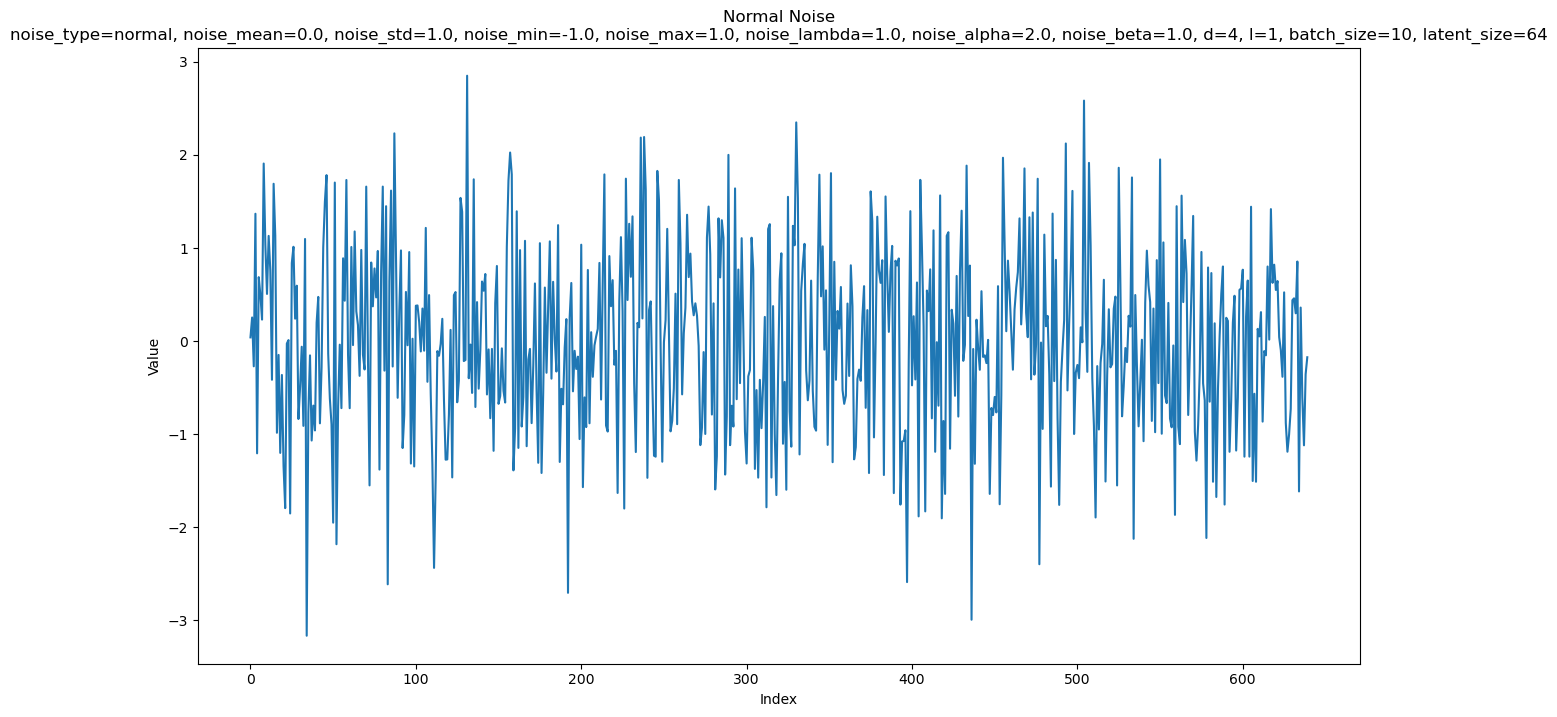

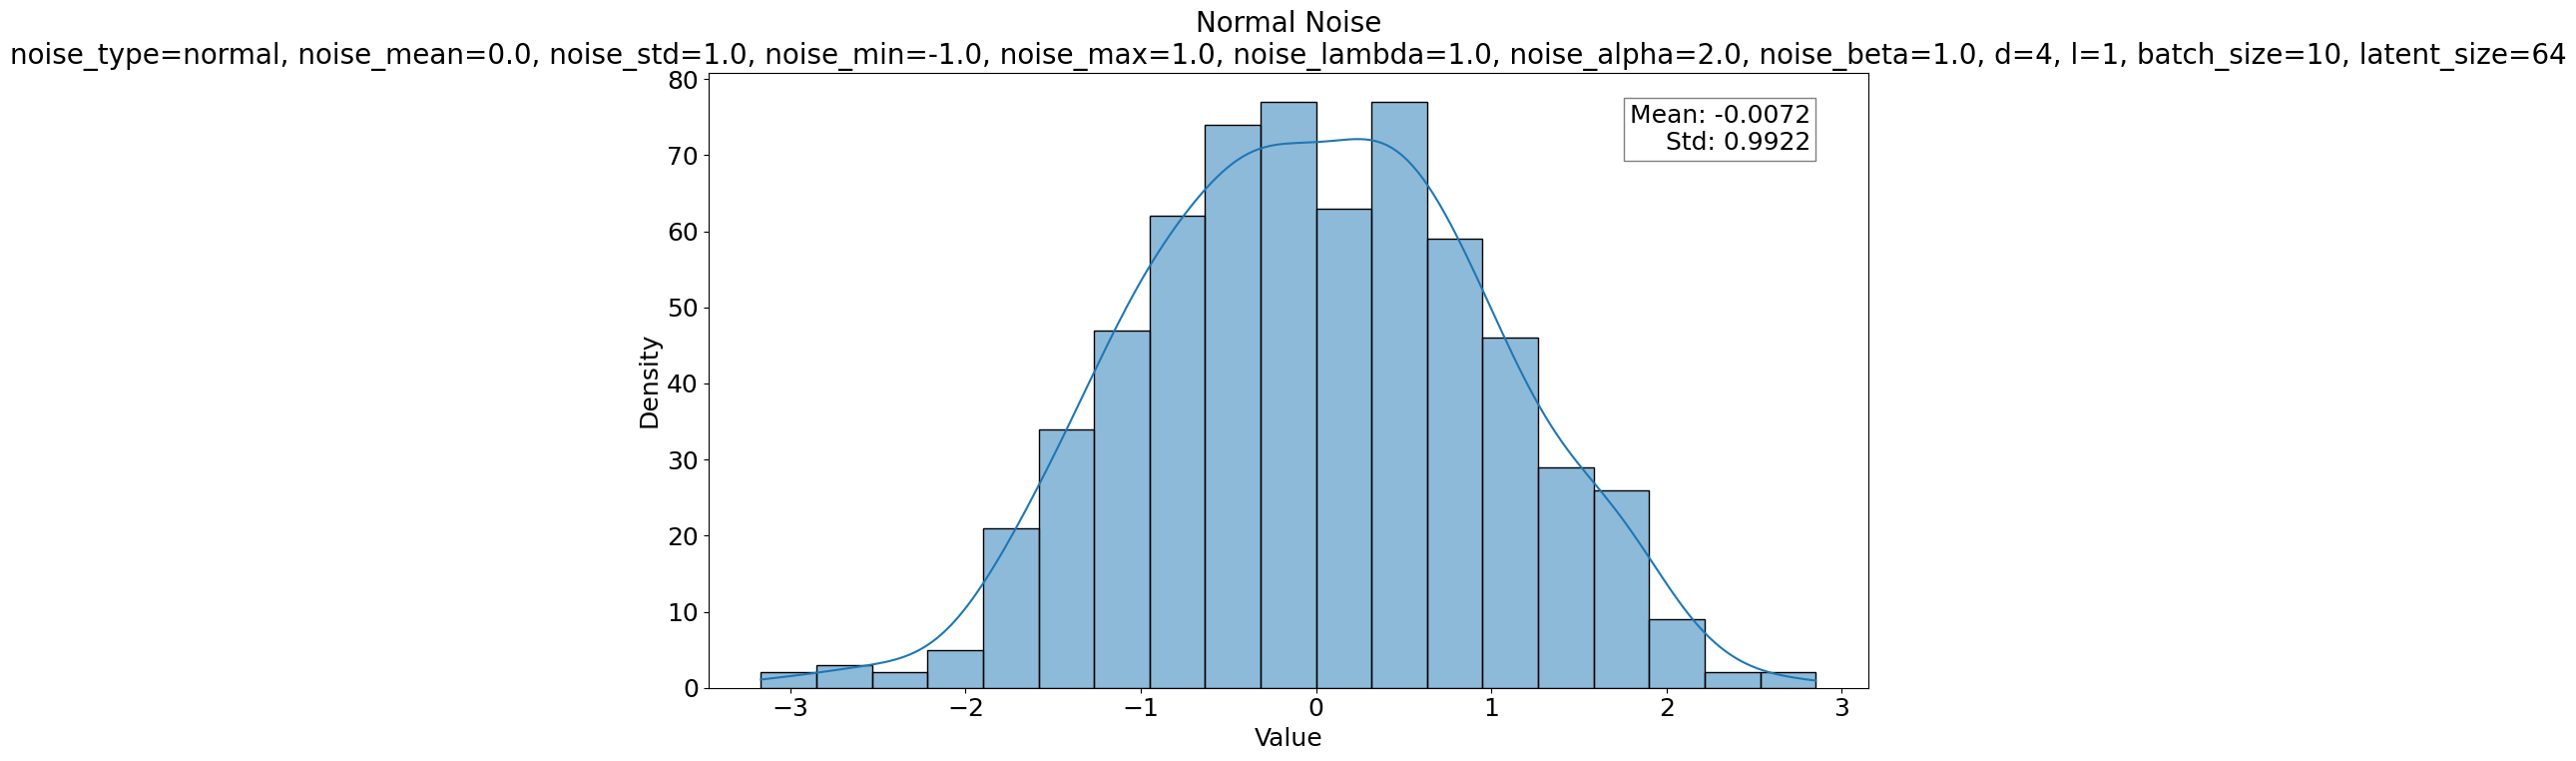

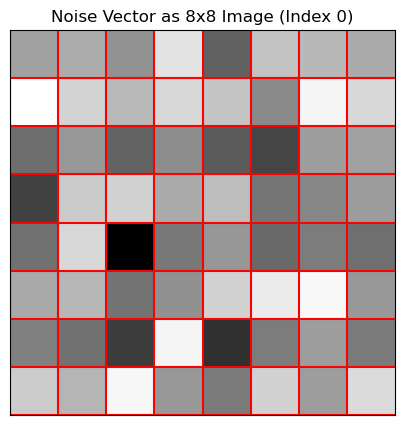

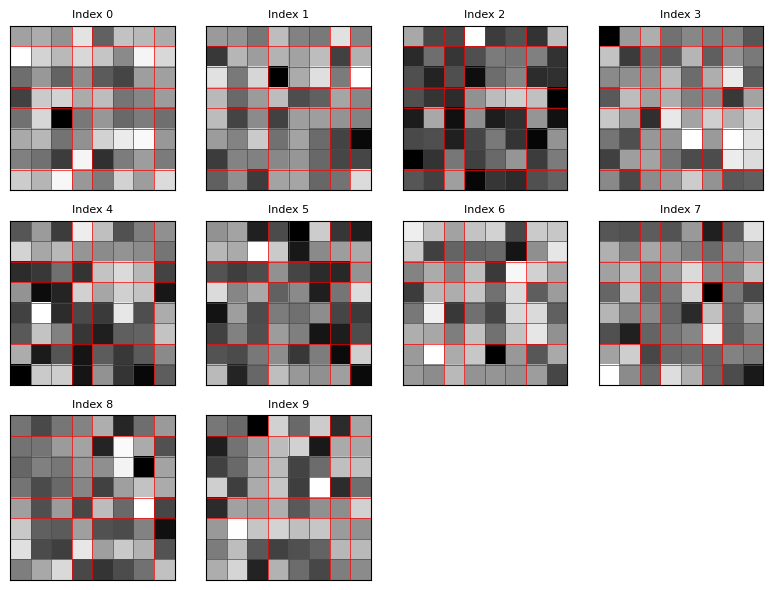

In [13]:
# Visualize noise
plot_noise_raw("normal", custom_noise_config, noise_vectors)
plot_noise_histogram(noise_vectors, "normal", custom_noise_config)
visualize_noise_as_image(noise_vectors, index=0, draw_grid=True)
visualize_all_noise_as_grid(noise_vectors, draw_grid=True)